In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hotel-classification-dataset.csv')
df.shape

(290315, 17)

In [ ]:
df.drop(columns=['Review_Date', 'lat', 'lng'], inplace=True)

In [ ]:
df['Tags'] = df['Tags'].astype(str)

In [ ]:
df['Tags'] = df['Tags'].apply(lambda x: eval(x.strip()))

# Tách các giá trị thành các cột riêng
tags_df = pd.DataFrame(df['Tags'].tolist())

# Đổi tên cột
tags_df.columns = [f"Tags_{i+1}" for i in range(tags_df.shape[1])]

# Kết hợp vào DataFrame ban đầu
df = pd.concat([df, tags_df], axis=1)

# Bỏ cột 'tag' gốc nếu không cần thiết
df = df.drop('Tags', axis=1)

In [ ]:
def normalize_value(value):
    value = str(value).strip().lower()
    if value in ['nothing', 'no negative', ' nothing', ' no negative', 'no positive', ' no postive']:
        return 'nothing'
    return value
df['Negative_Review'] = df['Negative_Review'].apply(normalize_value)
df['Positive_Review'] = df['Positive_Review'].apply(normalize_value)
df.head(10)

In [ ]:
# Bước 2: Chuyển "nothing" thành 0, tất cả các giá trị khác thành 1
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: 0 if x == "nothing" else 1)

In [ ]:
# Bước 2: Chuyển "nothing" thành 0, tất cả các giá trị khác thành 1
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: 0 if x == "nothing" else 1)

In [ ]:
mapping = {
    "Low_Reviewer_Score": 0,
    "Intermediate_Reviewer_Score": 0,
    "High_Reviewer_Score": 1
}

df['Reviewer_Score'] = df['Reviewer_Score'].map(mapping)

In [ ]:
cate_cols = df.select_dtypes(include=['object']).columns
cate_cols

Index(['Hotel_Address', 'Hotel_Name', 'Reviewer_Nationality', 'Tags_1',
       'Tags_2', 'Tags_3', 'Tags_4', 'Tags_5', 'Tags_6'],
      dtype='object')

In [ ]:
le = LabelEncoder()
for cols in cate_cols:
  df[cols] = le.fit_transform(df[cols])

<Axes: xlabel='Reviewer_Score', ylabel='Count'>

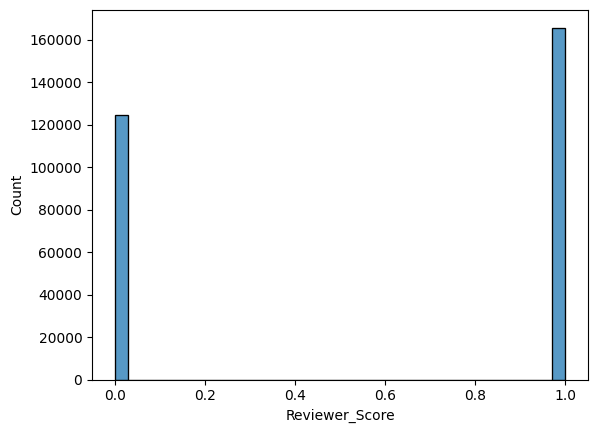

In [ ]:
sns.histplot(x=df['Reviewer_Score'])

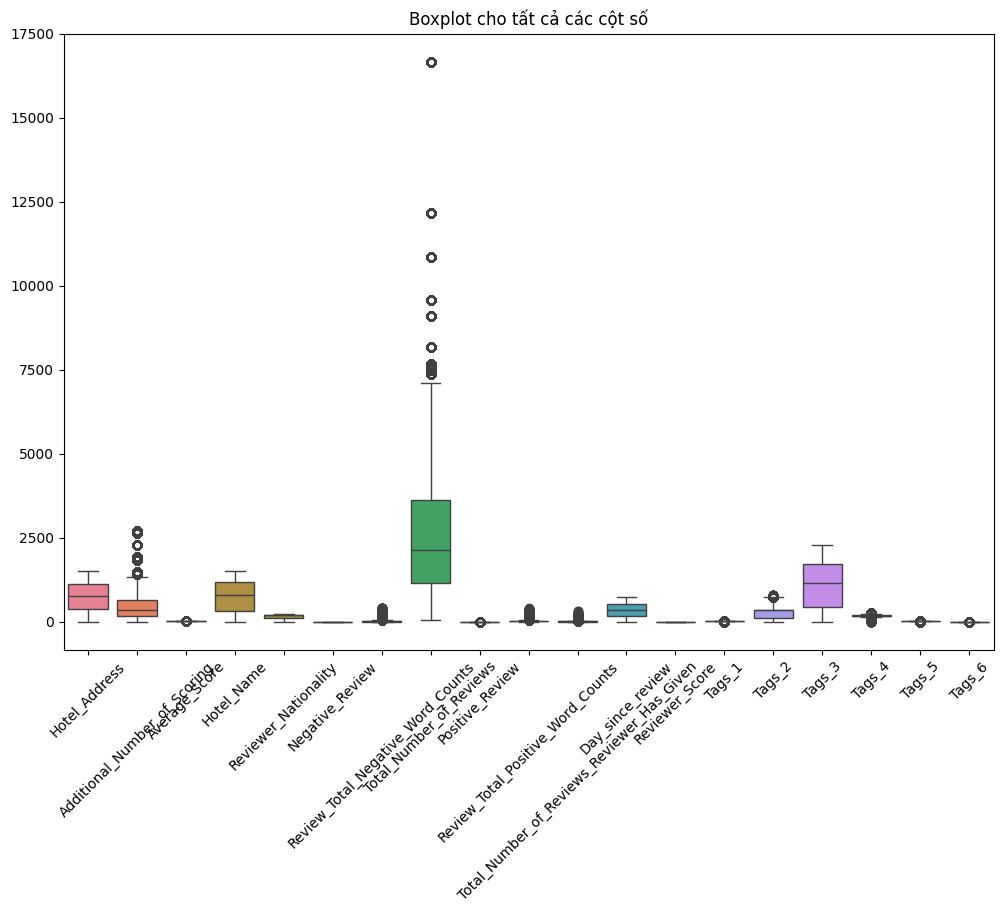

In [ ]:
plt.figure(figsize=(12, 8))

# Vẽ boxplot cho tất cả các cột số
sns.boxplot(data=df)

# Hiển thị
plt.xticks(rotation=90)
plt.title("Boxplot cho tất cả các cột số")
plt.show()

In [ ]:
for cols in df.columns:
  iqr = df[cols].quantile(0.75) - df[cols].quantile(0.25)
  upper_bound = df[cols].quantile(0.75) + 1.5 * iqr
  lower_bound = df[cols].quantile(0.25) - 1.5 * iqr
  df = df[(df[cols] >= lower_bound) & (df[cols] <= upper_bound)]

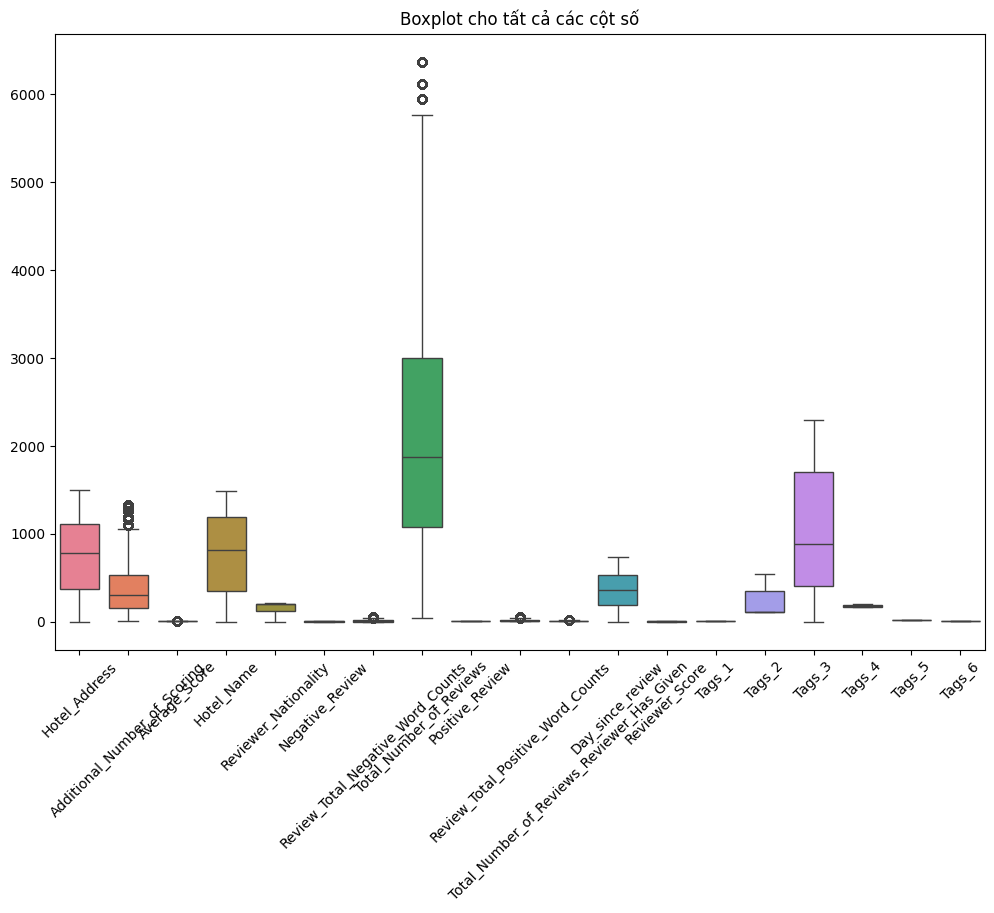

In [ ]:
plt.figure(figsize=(12, 8))

# Vẽ boxplot cho tất cả các cột số
sns.boxplot(data=df)

# Hiển thị
plt.xticks(rotation=90)
plt.title("Boxplot cho tất cả các cột số")
plt.show()

In [ ]:
X = df.drop(columns=['Reviewer_Score'])
y = df['Reviewer_Score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

,count
Reviewer_Score,
0,71244
1,71244


In [ ]:
clf_dt = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = clf_dt.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54     16618
           1       0.75      0.69      0.72     30707

    accuracy                           0.65     47325
   macro avg       0.63      0.63      0.63     47325
weighted avg       0.66      0.65      0.66     47325



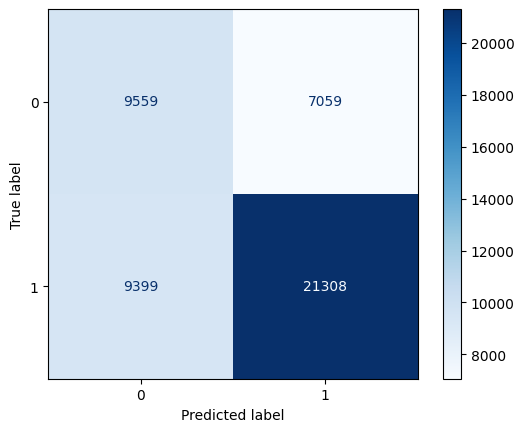

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt, X_test, y_test, cmap='Blues')

In [ ]:
# plt.figure(figsize=(12, 8))
# plot_tree(
#     clf_dt,
#     feature_names=X.columns,
#     class_names=["Class 0", "Class 1"],
#     filled=True,
#     rounded=True,
#     fontsize=10
# )
# plt.title("Decision Tree Visualization")
# plt.show()

# Tối ưu

In [ ]:
param_grid = {
    'max_depth': [5],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

In [ ]:
grid = GridSearchCV(clf_dt, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'], 'max_depth': [5],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [4, 8]},
             scoring='f1')

In [ ]:
y_proba = grid.predict_proba(X_test)[:, 1]

In [ ]:
threshold = np.arange(0.0, 1.01, 0.01)
results = []

for t in threshold:
    y_pred = (y_proba > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results.append((t, fp, fn, tp, tn))

In [ ]:
df_thresh = pd.DataFrame(results, columns=['threshold', 'fp', 'fn', 'tp', 'tn'])
df_thresh['Precision'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fp'])
df_thresh['Recall'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fn'])

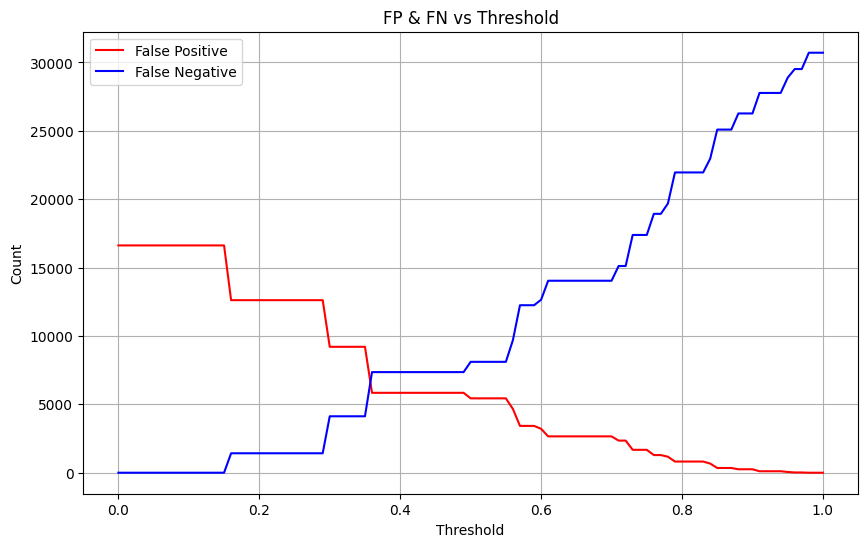

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh['threshold'], df_thresh['fp'], label='False Positive', color='red')
plt.plot(df_thresh['threshold'], df_thresh['fn'], label='False Negative', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('FP & FN vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Threshold = 0.44
y_pred_best = (y_proba > 0.44).astype(int)

In [ ]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62     16618
           1       0.80      0.76      0.78     30707

    accuracy                           0.72     47325
   macro avg       0.70      0.70      0.70     47325
weighted avg       0.73      0.72      0.72     47325



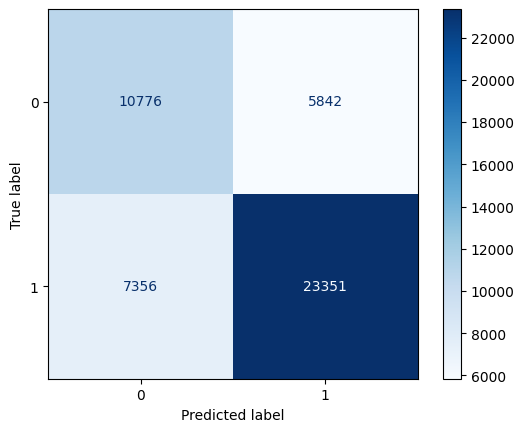

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_best,cmap='Blues')
plt.show()

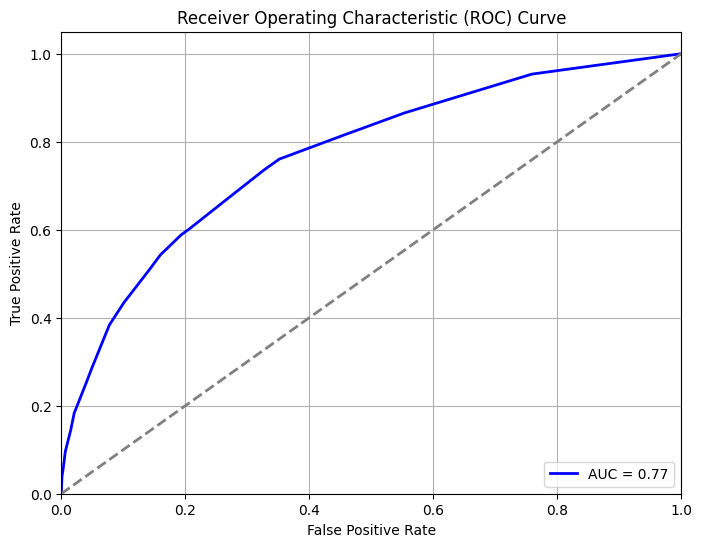

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

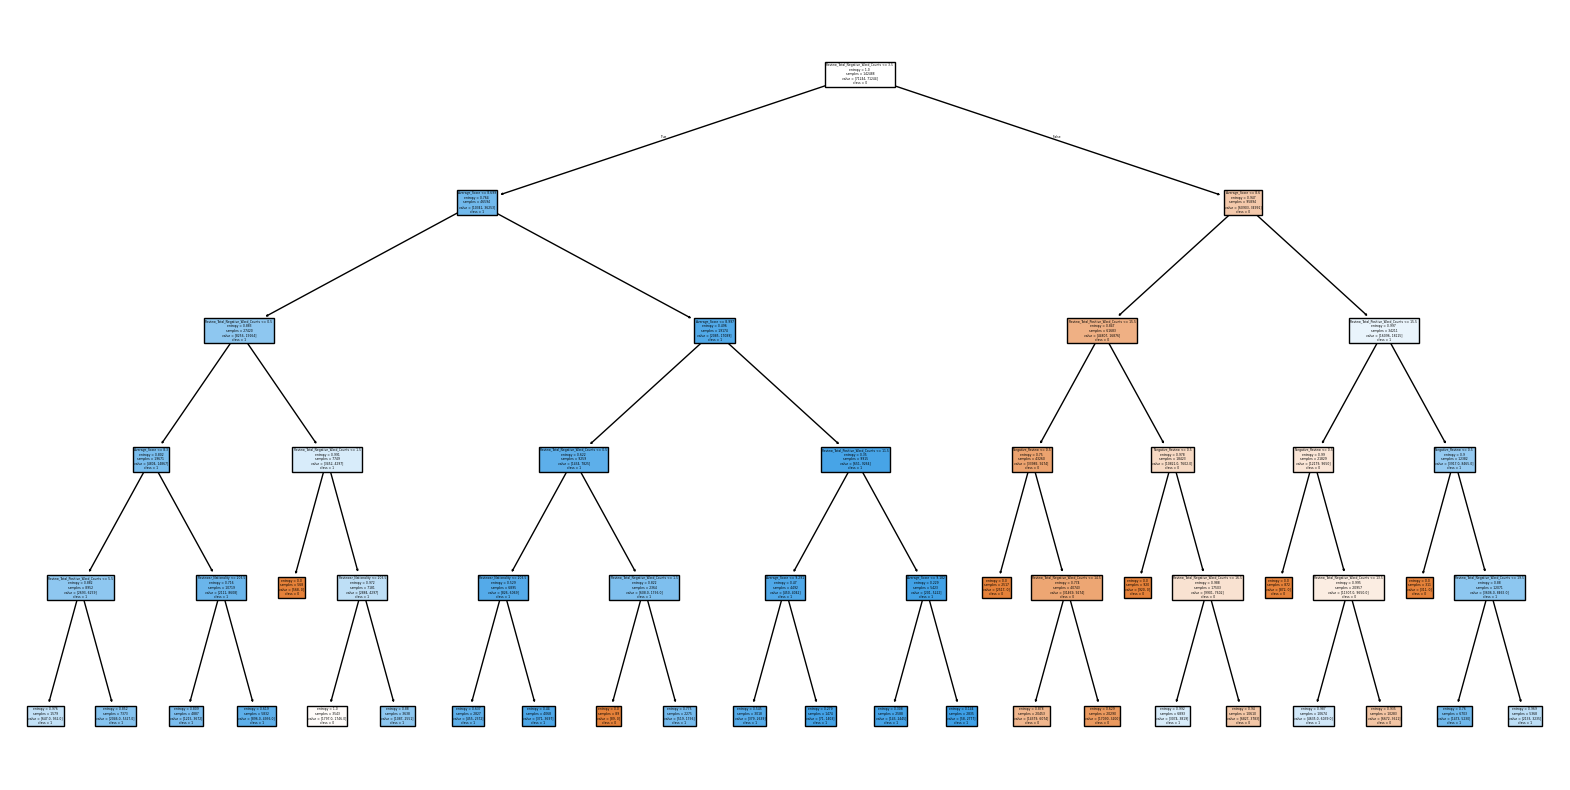

In [ ]:
best_clf_dt = grid.best_estimator_

plt.figure(figsize=(20,10))
plot_tree(best_clf_dt, filled=True, feature_names=df.columns[:-1], class_names=['0', '1'])
plt.show()

In [ ]:
X_train.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Average_Score',
       'Hotel_Name', 'Reviewer_Nationality', 'Negative_Review',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Positive_Review', 'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Day_since_review',
       'Tags_1', 'Tags_2', 'Tags_3', 'Tags_4', 'Tags_5', 'Tags_6'],
      dtype='object')